Analysis of weather and route time data 
=======
#### Ben Pheifer

In [1]:
import gspread
import json
from oauth2client.service_account import ServiceAccountCredentials
from weather_retrieve import weather
from distance_retrieve_method2 import duration
from datetime import datetime
import time
import calendar

# Importing libraries
import os
import warnings
warnings.filterwarnings('ignore')
## General packages for working with vectors, datasets, and visualization
import numpy as np
from numpy.random import normal, seed
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # This is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline
from pylab import rcParams
from plotly import tools
import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

## Packages for analyzing time series
import statsmodels.api as sm
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

### Authorise Google API

In [2]:
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
google_cred = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scope)
gc = gspread.authorize(google_cred)



In [3]:
datasheet = gc.open("SIOTData").sheet1
headers = datasheet.row_values(1)
print headers
print type(headers[0])
for i in range(1, len(headers)+1):
    headers[i-1] = datasheet.col_values(i)
date_time, cloud_cover, apparent_temperature, precipitation, school, work, uni, holiday = headers
print school[0:5]
#pandadata = pd.read_csv(datasheet)

[u'Date and Time', u'Cloud Cover (0-1)', u'Apparent Temperature (\xb0C)', u'Precipitation', u'School Run (s)', u'Work Commute (s)', u'University Commute (s)', u'Cross Country Trip (s)']
<type 'unicode'>
[u'School Run (s)', u'1005', u'987', u'988', u'968']


In [4]:
datasheet = gc.open("SIOTData").sheet1
headers = datasheet.row_values(1)

#print headers
for i in range(1, len(headers)+1):
    headers[i-1] = datasheet.col_values(i)
    
date_time, cloud_cover, apparent_temperature, precipitation, school, work, uni, holiday = headers

plt.figure(figsize=(20, 10))
t = 1
#print date_time
while t < len(date_time):
    #print t
    if date_time[t] == '':
        date_time[t] = date_time[t-1]
        pass
    else:
        x = date_time[t].encode("ascii")
        #print date_time[t]
        #print x
        y = datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
        date_time[t] = y
        #print date_time[t]
    t += 1
    
print date_time[0]
def convertfloat(column):
    for i in range(2, len(column)):
        if column[i] == '':
            column[i] = float(column[i-1])
        else:
            column[i] = float(column[i])  
    return column
            
cloud_cover = convertfloat(cloud_cover)  

            
#print cloud_cover
data_dictionary = {date_time[0]:date_time[1:], cloud_cover[0]:cloud_cover[1:], apparent_temperature[0]:apparent_temperature[1:], precipitation[0]:precipitation[1:], school[0]:school[1:], work[0]:work[1:], uni[0]:uni[1:], holiday[0]:holiday[1:]}
df = pd.DataFrame(data=data_dictionary)



Date and Time


In [5]:
print type(date_time[1])

<type 'datetime.datetime'>


In [6]:
name_list = list(df)

df['Cloud Cover (0-1)'].head()

0    0.77
1    0.77
2    0.78
3    0.78
4    0.78
Name: Cloud Cover (0-1), dtype: object

In [7]:
cloud_floats = ['Cloud Floats']
for i in range(2, len(cloud_cover)):
    #if cloud_cover[i] == '':
     #   cloud_floats.append(float(cloud_cover[i-1]))
    #else:
    cloud_floats.append(float(cloud_cover[i]))


In [8]:
temp_floats = ['Temp Floats']
for i in range(1, len(apparent_temperature)):
    #if apparent_temperature[i] == '':
     #   temp_floats.append(temp_floats[-1])
    #else:
    try:
        temp_floats.append(float(apparent_temperature[i]))
    except:
        temp_floats.append(None)
        pass
#print temp_floats

In [9]:
precip_floats = ['Precip Floats']
for i in range(2, len(precipitation)):
    #if precipitation[i] == '':
     #   precip_floats.append(float(precip_floats[-1]))
    #else:
    try:
        precip_floats.append(float(precipitation[i]))
    except:
        precip_floats.append(None)
        pass
#print precip_floats

In [10]:
school_float = ['School Floats']
for i in range(1, len(school)):
    #if precipitation[i] == '':
     #   precip_floats.append(float(precip_floats[-1]))
    #else:
    try:
        school_float.append(float(school[i]))
    except:
        school_float.append(None)
        pass
#print school_float

In [11]:
work_float = ['Work Floats']
for i in range(1, len(work)):
    #if precipitation[i] == '':
     #   precip_floats.append(float(precip_floats[-1]))
    #else:
    try:
        work_float.append(float(work[i]))
    except:
        work_float.append(None)
        pass
print type(work_float[1])

<type 'float'>


In [12]:
uni_float = ['Uni Floats']
for i in range(1, len(uni)):
    #if precipitation[i] == '':
     #   precip_floats.append(float(precip_floats[-1]))
    #else:
    try:
        uni_float.append(float(uni[i]))
    except:
        uni_float.append(None)
        pass
print type(uni_float[1])

<type 'float'>


In [13]:
holiday_float = ['Holiday Floats']
for i in range(1, len(holiday)):
    #if precipitation[i] == '':
     #   precip_floats.append(float(precip_floats[-1]))
    #else:
    try:
        holiday_float.append(float(holiday[i]))
    except:
        holiday_float.append(None)
        pass
print type(holiday_float[1])

<type 'float'>


In [14]:
seen = {}
dupes = []

for x in date_time:
    if x not in seen:
        seen[x] = 1
    else:
        if seen[x] == 1:
            dupes.append(x)
        seen[x] += 1
print dupes

[]


In [15]:
#print date_time[1:]
df = pd.DataFrame(data=[cloud_floats[1:],temp_floats[1:], precip_floats[1:], school_float[1:], work_float[1:], uni_float[1:], holiday_float[1:]],
                 index=[cloud_floats[0],temp_floats[0], precip_floats[0], school_float[0], work_float[0], uni_float[0], holiday_float[0]], 
                 columns=date_time[1:]
                 )
dft =df.T
#print dft

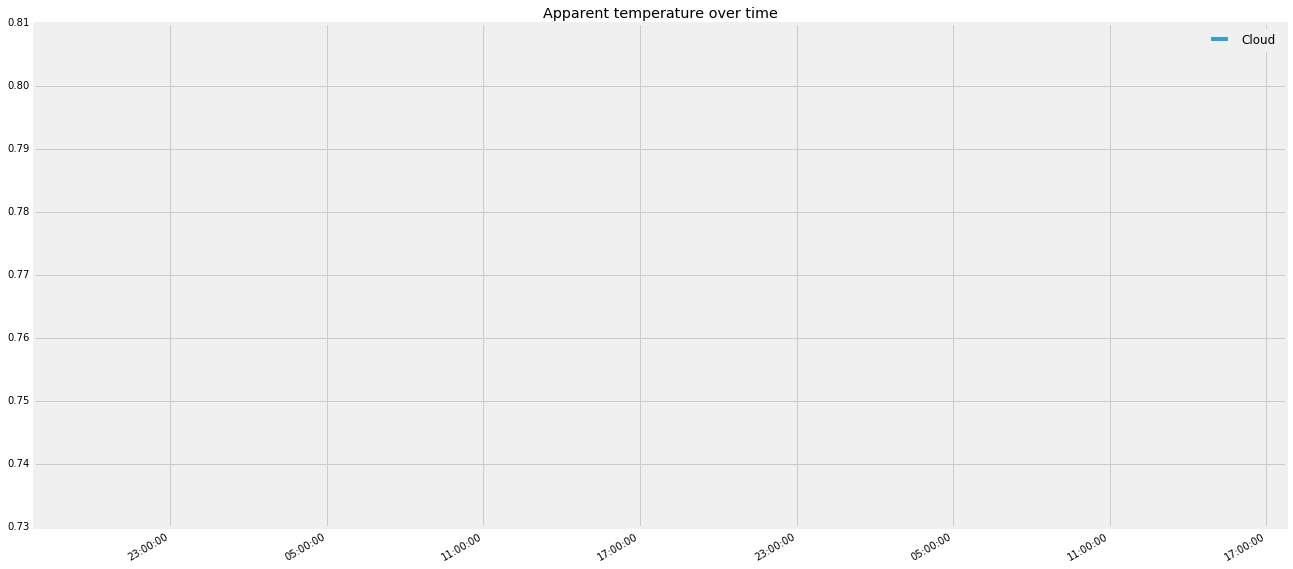

In [24]:
plt.figure(figsize=(20, 10))

dft['Cloud Floats'].asfreq(freq = 'D').plot(label ="Cloud")
plt.label =("Cloud Cover") 
plt.title("Apparent temperature over time")
plt.legend()
plt.show()

<class 'pandas.core.series.Series'>


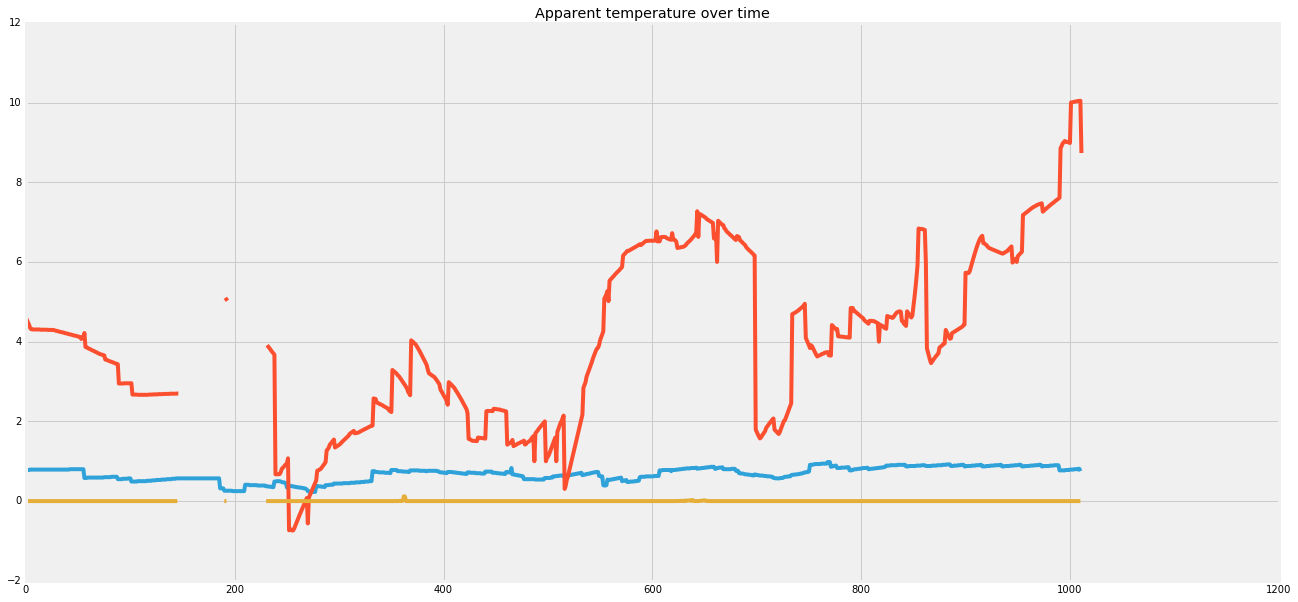

In [17]:
#plt.plot (date_time[2:], apparent_temperature[2:])
plt.figure(figsize=(20, 10))
print type(dft['Cloud Floats'])
cc = dft['Cloud Floats']
plt.plot(cloud_floats[1:])
plt.plot(temp_floats[1:])
plt.plot(precip_floats[1:])
#plt.plot(c)
plt.label =("Cloud Cover") 
plt.title("Apparent temperature over time")
plt.legend()
plt.show()

Precipitation data ommitted due to dry weatherf period.

In [18]:
plt.figure(figsize=(20,10))
#ncloud = (cloud_floats - np.mean(cloud_floats)/np.std(cloud_floats))
ntemp = (temp_floats - np.mean(temp_floats)/np.std(temp_floats))

         
plt.plot(cloud_floats, label="Cloud Cover")
plt.plot(ntemp, label="Apparent Temperature")
         
plt.title('Normalised cloud cover and apparent temperature over time (Monthly frequency)')
plt.legend()
plt.show()

TypeError: cannot concatenate 'str' and 'float' objects

In [26]:
#plt.plot (date_time[2:], apparent_temperature[2:])
plt.figure(figsize=(20, 10))
print type(df['School Run (s)'][0])
cc = df['School Run (s)']
plt.plot(cc)
plt.plot(df['Work Commute (s)'])
plt.plot(df['University Commute (s)'])
#plt.plot(c)
#plt.label =("Cloud Cover") 
plt.title("Journey Times Over Time :: (Holiday Omitted for scale)")
plt.legend()
plt.show()

KeyError: 'School Run (s)'

In [25]:
df["School Run (s)"].asfreq(freq='60s', method='bfill').plot(label ="schooltime") 


KeyError: 'School Run (s)'